In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os

print("Files inside /kaggle/input/apple-dataset/:")
print(os.listdir("/kaggle/input/apple-dataset"))


Files inside /kaggle/input/apple-dataset/:
['IMDB Dataset.csv']


Shape: (50000, 2)
Columns: ['review', 'sentiment']

--- First 5 rows ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

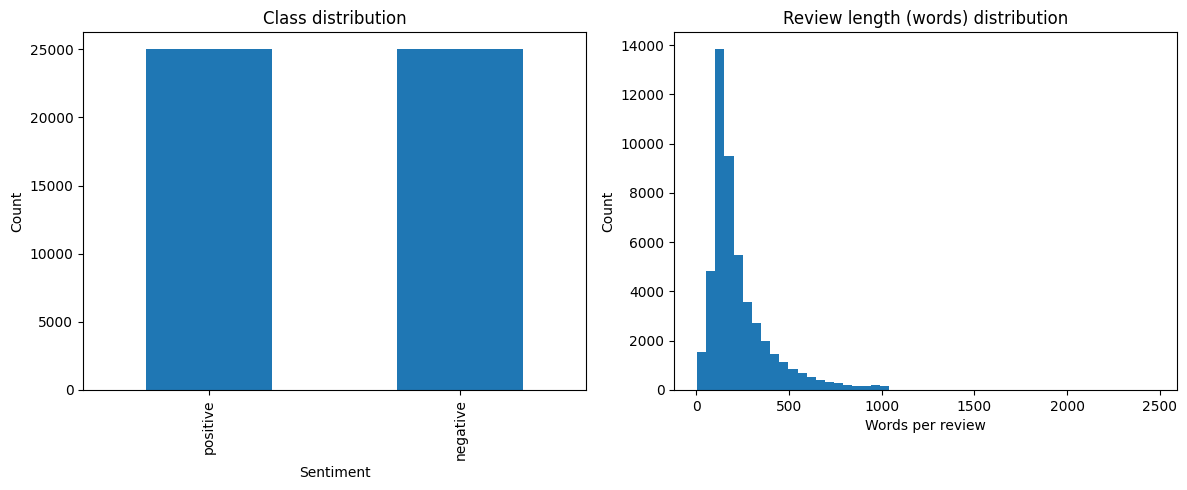


Saved a 10% sample to IMDB_reviews_sample_10pct.csv

--- Sample cleaned reviews ---
                                        review_clean  label
0  one of the other reviewers has mentioned that ...      1
1  a wonderful little production the filming tech...      1
2  i thought this was a wonderful way to spend ti...      1
3  basically there s a family where a little boy ...      0
4  petter mattei s love in the time of money is a...      1


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re
import string

# Load dataset
df = pd.read_csv("/kaggle/input/apple-dataset/IMDB Dataset.csv")

# --- Exploration ---
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\n--- First 5 rows ---")
print(df.head(5).to_string(index=False))

print("\n--- Sentiment value counts ---")
print(df['sentiment'].value_counts(dropna=False))

print("\n--- Missing values per column ---")
print(df.isnull().sum())

# Ensure review column is string
df['review'] = df['review'].astype(str)

# Review length stats
df['review_len_chars'] = df['review'].apply(len)
df['review_len_words'] = df['review'].str.split().apply(len)
print("\n--- Review length (chars) stats ---")
print(df['review_len_chars'].describe().to_string())
print("\n--- Review length (words) stats ---")
print(df['review_len_words'].describe().to_string())

# Sample positive & negative reviews
print("\n--- Sample positive reviews (5) ---")
pos = df[df['sentiment'] == 'positive']
print(pos['review'].sample(5, random_state=42).to_string(index=False))

print("\n--- Sample negative reviews (5) ---")
neg = df[df['sentiment'] == 'negative']
print(neg['review'].sample(5, random_state=42).to_string(index=False))

# Top words overall
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(df['review'])
sum_words = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
top_idx = np.argsort(sum_words)[-20:][::-1]
print("\n--- Top 20 words (overall, stopwords removed) ---")
for idx in top_idx:
    print(f"{words[idx]}: {sum_words[idx]}")

# Visualization
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Class distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(df['review_len_words'], bins=50)
plt.title('Review length (words) distribution')
plt.xlabel('Words per review')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Optional: Save a 10% sample for faster experimentation
df.sample(frac=0.1, random_state=42).to_csv("IMDB_reviews_sample_10pct.csv", index=False)
print("\nSaved a 10% sample to IMDB_reviews_sample_10pct.csv")

# --- Preprocessing ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)  # remove HTML tags
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df['review_clean'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive':1, 'negative':0})

print("\n--- Sample cleaned reviews ---")
print(df[['review_clean','label']].head())



=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9030    0.8840    0.8934      5000
           1     0.8864    0.9050    0.8956      5000

    accuracy                         0.8945     10000
   macro avg     0.8947    0.8945    0.8945     10000
weighted avg     0.8947    0.8945    0.8945     10000



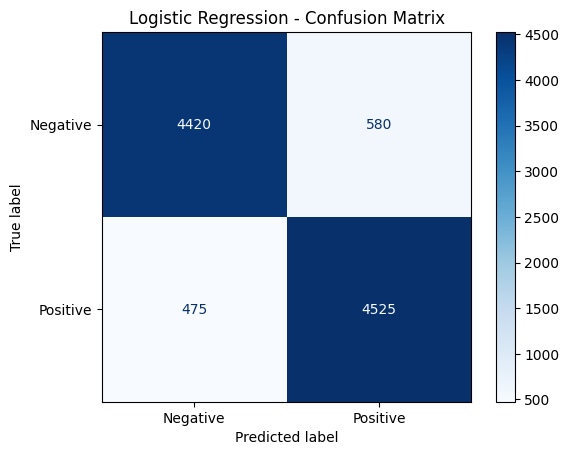


=== Linear SVM ===
              precision    recall  f1-score   support

           0     0.8894    0.8844    0.8869      5000
           1     0.8850    0.8900    0.8875      5000

    accuracy                         0.8872     10000
   macro avg     0.8872    0.8872    0.8872     10000
weighted avg     0.8872    0.8872    0.8872     10000



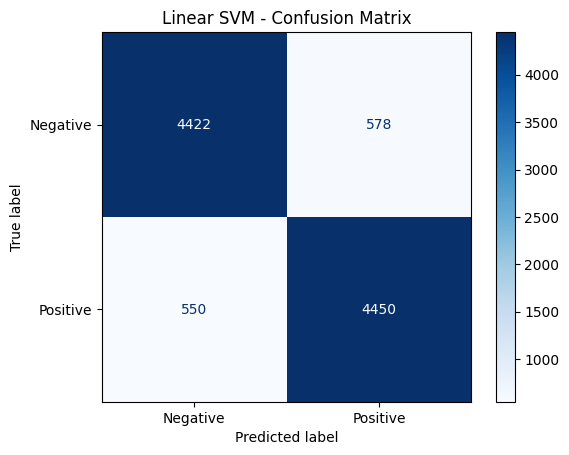


=== Model Comparison ===
                 model  accuracy  precision  recall        f1
0  Logistic Regression    0.8945   0.886386   0.905  0.895596
1           Linear SVM    0.8872   0.885044   0.890  0.887515


<Figure size 800x500 with 0 Axes>

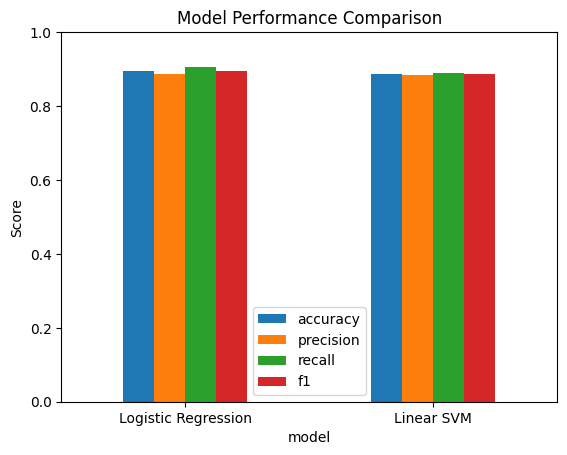

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Features & labels
X = df['review_clean']
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# --- Logistic Regression ---
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_tfidf, y_train)
y_pred_lr = log_reg.predict(X_test_tfidf)

# --- Linear SVM ---
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n=== {model_name} ===")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()
    return {
        "model": model_name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }

# Evaluate both models
results = []
results.append(evaluate_model(y_test, y_pred_lr, "Logistic Regression"))
results.append(evaluate_model(y_test, y_pred_svm, "Linear SVM"))

# Comparison
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)

# Plot comparison
plt.figure(figsize=(8,5))
results_df.set_index("model")[["accuracy","precision","recall","f1"]].plot(kind='bar')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()
